In [355]:
import pandas as pd

import numpy as np
pd.set_option('display.max_columns', None)

import rdkit.Chem as Chem
import datamol as dm
import matplotlib.pyplot as plt
import seaborn as sns

# Suppress FutureWarning
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)


In [356]:
from sklearn.preprocessing import StandardScaler 
def do_scaling(scaler=StandardScaler(), xtrain=None, xtest=None):
    """
    Usage: do_scaling(scaler=MinMaxScaler(), xtrain=xtrain, xtest=test) 
    xtrain and xtest are pd.Dataframes
    Caution: Do test_train_split before scaling
    Return: return scaled non-None xtrain and xtest
    """
    st = scaler

    if xtrain is not None:
        col=xtrain.columns.values.tolist()
        xtrain=st.fit_transform(xtrain)  
        xtrain=pd.DataFrame(xtrain,columns=col)

        if xtest is not None:
            
            xtest=st.transform(xtest)
            xtest=pd.DataFrame(xtest,columns=col)
            print("returning scaled train and test data")
            return xtrain,xtest
        else:
            print("test data is not provided, returning only scaled train data")
            return xtrain
    else:
        print("Give train data, returning None")
        return xtrain,xtest

In [357]:
def substruct_in_smi(mol_smi_str,pat_smi_str):
    """
    This function will return True if the substructure (pattern) is present in the SMILES string.
    Input: smi_str = A SMILES string;   sub_str = Pattern 
    Output: True (substruture found in the smi); False (substruture not found in the smi)
    """   
    mol = Chem.MolFromSmiles(mol_smi_str)
    pat = Chem.MolFromSmiles(pat_smi_str) 

    return mol.HasSubstructMatch(pat)

In [358]:
def All_Mordred_descriptors(data,ignore_3D=True):
    """
    Function will return all mordred features
    """
    from mordred import Calculator, descriptors
    from rdkit.Chem import AllChem
    calc = Calculator(descriptors, ignore_3D=ignore_3D)
    # mols = [Chem.AddHs(Chem.MolFromSmiles(smi)) for smi in data]
    mols = []
    for smi in data:
        m=Chem.MolFromSmiles(smi)
        if not ignore_3D:
            m=Chem.AddHs(m) # for 3D descriptors
            AllChem.EmbedMolecule(m) # for 3D descriptors
            AllChem.UFFOptimizeMolecule(m)  # for 3D descriptors
        mols.append(m)
    # pandas df
    df = calc.pandas(mols)
    return df

In [359]:
def data_cleaning(df):
    # check columns with nan
    columns_with_nan=df.columns[df.isna().any()]
    print(f"Removing {len(columns_with_nan)} columns with nan, if any")
    print(f"Before: df.shape={df.shape}")
    df = df.dropna(axis='columns')
    # df = df.drop(columns=columns_with_nan)
    print(f"After: df.shape={df.shape} \n")    
    

    # Remove duplicates
    print(f"removing {sum(df.columns.duplicated())} duplicate columns, if any")
    print(f"Before: df.shape={df.shape}")
    df=df.loc[:,~df.columns.duplicated()].copy()
    print(f"After: df.shape={df.shape} \n")
    
    
    # Remove columns with a unique value
    print(f"removing {sum(df.nunique()<2)} columns values with a unique value")
    print(f"Before: df.shape={df.shape}")
    df=df.loc[:,df.nunique()>1]
    print(f"After: df.shape={df.shape} \n")
    
    print("returning a clean df")
    return df


In [360]:
# # only limited descriptors
# from mordred import Calculator,descriptors
# from mordred.descriptors import HydrogenBond, RotatableBond, Weight, Aromatic, RingCount, AtomCount

# mols=[Chem.MolFromSmiles(smi) for smi in df_mordred["SMILES"]]
# df_mordred_limited = Calculator([	HydrogenBond, RotatableBond, Weight, Aromatic, RingCount, AtomCount],ignore_3D=True).pandas(mols=mols)
# df_mordred_limited.head()

In [361]:
def RDkit_descriptors(smiles):
    """
    Function will return all 208 RDKit descriptors
    smiles is a pandas series or a list of smiles
    """
    from rdkit.ML.Descriptors import MoleculeDescriptors
    from rdkit.Chem import Descriptors
    mols = [Chem.MolFromSmiles(i) for i in smiles] 
    calc = MoleculeDescriptors.MolecularDescriptorCalculator([x[0] for x in Descriptors._descList])
    desc_names = calc.GetDescriptorNames()
    
    Mol_descriptors =[]
    for mol in mols:
        # add hydrogens to molecules
        mol=Chem.AddHs(mol)
        # Calculate all 208 descriptors for each molecule
        descriptors = calc.CalcDescriptors(mol)
        Mol_descriptors.append(descriptors)
    return Mol_descriptors,desc_names 

In [362]:
df22=pd.read_csv(r"C:\Users\jaina\Box\Eli-Garvit-BzNSN\Manuscript_Figure_Analysis\Data\00_DFT_1594_clean.csv",usecols=["smiles","complexity","DelE_red(V)"])
df22_rdkit=pd.read_csv(r"C:\Users\jaina\Box\Eli-Garvit-BzNSN\Manuscript_Figure_Analysis\Data\00_DFT_1594_clean_features.csv")

In [363]:
print(df22.shape)
df22.head()

(1569, 3)


,smiles,complexity,DelE_red(V)
0,Cc1c2c(cc3nsnc13)N(C)CCN2CCN(C)C,8,1.27
1,CCN1CCN(CCOC)c2c1cc1nsnc1c2C,7,1.27
2,CCNc1c2c(cc3nsnc13)N(C)CCN2C(C)C,6,1.24
3,CCCN1CCN(CC)c2cc3nsnc3c(NCC)c21,6,1.22
4,CCNc1c2c(cc3nsnc13)N(CC)CCN2C(C)C,6,1.20


In [364]:
print(df22_rdkit.shape)
df22_rdkit.head()

(1569, 125)


,sssr,clogp,mr,mw,tpsa,chi0n,chi1n,chi2n,chi3n,chi4n,chi0v,chi1v,chi2v,chi3v,chi4v,fracsp3,hall_kier_alpha,kappa1,kappa2,kappa3,labuteasa,number_aliphatic_rings,number_aromatic_rings,number_amide_bonds,number_atom_stereocenters,number_bridgehead_atoms,number_HBA,number_HBD,number_hetero_atoms,number_hetero_cycles,number_rings,number_rotatable_bonds,number_spiro,number_saturated_rings,number_heavy_atoms,number_nh_oh,number_n_o,number_valence_electrons,max_partial_charge,min_partial_charge,fr_C_O,fr_C_O_noCOO,fr_Al_OH,fr_Ar_OH,fr_methoxy,fr_oxime,fr_ester,fr_Al_COO,fr_Ar_COO,fr_COO,fr_COO2,fr_ketone,fr_ether,fr_phenol,fr_aldehyde,fr_quatN,fr_NH2,fr_NH1,fr_NH0,fr_Ar_N,fr_Ar_NH,fr_aniline,fr_Imine,fr_nitrile,fr_hdrzine,fr_hdrzone,fr_nitroso,fr_N_O,fr_nitro,fr_azo,fr_diazo,fr_azide,fr_amide,fr_priamide,fr_amidine,fr_guanido,fr_Nhpyrrole,fr_imide,fr_isocyan,fr_isothiocyan,fr_thiocyan,fr_halogen,fr_alkyl_halide,fr_sulfide,fr_SH,fr_C_S,fr_sulfone,fr_sulfonamd,fr_prisulfonamd,fr_barbitur,fr_urea,fr_term_acetylene,fr_imidazole,fr_furan,fr_thiophene,fr_thiazole,fr_oxazole,fr_pyridine,fr_piperdine,fr_piperzine,fr_morpholine,fr_lactam,fr_lactone,fr_tetrazole,fr_epoxide,fr_unbrch_alkane,fr_bicyclic,fr_benzene,fr_phos_acid,fr_phos_ester,fr_nitro_arom,fr_nitro_arom_nonortho,fr_dihydropyridine,fr_phenol_noOrthoHbond,fr_Al_OH_noTert,fr_benzodiazepine,fr_para_hydroxylation,fr_allylic_oxid,fr_aryl_methyl,fr_Ndealkylation1,fr_Ndealkylation2,fr_alkyl_carbamate,fr_ketone_Topliss,fr_ArN,fr_HOCCN
0,3,1.81752,86.1890,291.151767,35.50,12.550094,6.943478,5.713135,3.990306,2.790050,13.366590,7.673774,6.241583,4.532875,3.370123,0.571429,-1.40,13.577001,5.179478,2.226066,123.668114,1,2,0,0,0,6,0,6,2,3,3,0,0,20,0,5,108,0.109421,-0.371076,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,5,2,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,1,0,0,0,0,0,0,0,0,0,0,1,2,0,0,0,0,0
1,3,2.29242,84.1280,292.135782,41.49,12.218235,7.005867,5.060772,3.984172,2.920064,13.034732,7.736164,5.589220,4.526742,3.500137,0.571429,-1.40,13.577001,5.535354,2.125124,123.021825,1,2,0,0,0,6,0,6,2,3,4,0,0,20,0,5,108,0.109421,-0.382853,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,4,2,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,1,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0
2,3,2.78770,87.3307,291.151767,44.29,12.473124,7.140155,5.490284,3.855243,2.834057,13.289620,7.870451,6.018731,4.397813,3.368486,0.571429,-1.56,13.424314,5.086989,1.984487,123.458142,1,2,0,0,0,6,1,6,2,3,3,0,0,20,1,5,108,0.129670,-0.381730,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,4,2,0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
3,3,3.17940,91.9697,305.167417,44.29,13.017094,7.826711,5.348303,4.029118,3.102774,13.833590,8.557007,5.876751,4.571688,3.637203,0.600000,-1.56,14.380319,6.052915,2.413726,129.823084,1,2,0,0,0,6,1,6,2,3,5,0,0,21,1,5,114,0.129670,-0.381730,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,4,2,0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
4,3,3.17780,91.9477,305.167417,44.29,13.180230,7.716276,5.648397,4.100912,3.083301,13.996727,8.446572,6.176845,4.643482,3.617731,0.600000,-1.56,14.380319,5.673993,2.310895,129.823084,1,2,0,0,0,6,1,6,2,3,4,0,0,21,1,5,114,0.129670,-0.381730,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,4,2,0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0


In [365]:
df22_rdkit.insert(0,"smiles",df22.smiles)

In [366]:
print(df22_rdkit.shape)
df22_rdkit.head()

(1569, 126)


,smiles,sssr,clogp,mr,mw,tpsa,chi0n,chi1n,chi2n,chi3n,chi4n,chi0v,chi1v,chi2v,chi3v,chi4v,fracsp3,hall_kier_alpha,kappa1,kappa2,kappa3,labuteasa,number_aliphatic_rings,number_aromatic_rings,number_amide_bonds,number_atom_stereocenters,number_bridgehead_atoms,number_HBA,number_HBD,number_hetero_atoms,number_hetero_cycles,number_rings,number_rotatable_bonds,number_spiro,number_saturated_rings,number_heavy_atoms,number_nh_oh,number_n_o,number_valence_electrons,max_partial_charge,min_partial_charge,fr_C_O,fr_C_O_noCOO,fr_Al_OH,fr_Ar_OH,fr_methoxy,fr_oxime,fr_ester,fr_Al_COO,fr_Ar_COO,fr_COO,fr_COO2,fr_ketone,fr_ether,fr_phenol,fr_aldehyde,fr_quatN,fr_NH2,fr_NH1,fr_NH0,fr_Ar_N,fr_Ar_NH,fr_aniline,fr_Imine,fr_nitrile,fr_hdrzine,fr_hdrzone,fr_nitroso,fr_N_O,fr_nitro,fr_azo,fr_diazo,fr_azide,fr_amide,fr_priamide,fr_amidine,fr_guanido,fr_Nhpyrrole,fr_imide,fr_isocyan,fr_isothiocyan,fr_thiocyan,fr_halogen,fr_alkyl_halide,fr_sulfide,fr_SH,fr_C_S,fr_sulfone,fr_sulfonamd,fr_prisulfonamd,fr_barbitur,fr_urea,fr_term_acetylene,fr_imidazole,fr_furan,fr_thiophene,fr_thiazole,fr_oxazole,fr_pyridine,fr_piperdine,fr_piperzine,fr_morpholine,fr_lactam,fr_lactone,fr_tetrazole,fr_epoxide,fr_unbrch_alkane,fr_bicyclic,fr_benzene,fr_phos_acid,fr_phos_ester,fr_nitro_arom,fr_nitro_arom_nonortho,fr_dihydropyridine,fr_phenol_noOrthoHbond,fr_Al_OH_noTert,fr_benzodiazepine,fr_para_hydroxylation,fr_allylic_oxid,fr_aryl_methyl,fr_Ndealkylation1,fr_Ndealkylation2,fr_alkyl_carbamate,fr_ketone_Topliss,fr_ArN,fr_HOCCN
0,Cc1c2c(cc3nsnc13)N(C)CCN2CCN(C)C,3,1.81752,86.1890,291.151767,35.50,12.550094,6.943478,5.713135,3.990306,2.790050,13.366590,7.673774,6.241583,4.532875,3.370123,0.571429,-1.40,13.577001,5.179478,2.226066,123.668114,1,2,0,0,0,6,0,6,2,3,3,0,0,20,0,5,108,0.109421,-0.371076,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,5,2,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,1,0,0,0,0,0,0,0,0,0,0,1,2,0,0,0,0,0
1,CCN1CCN(CCOC)c2c1cc1nsnc1c2C,3,2.29242,84.1280,292.135782,41.49,12.218235,7.005867,5.060772,3.984172,2.920064,13.034732,7.736164,5.589220,4.526742,3.500137,0.571429,-1.40,13.577001,5.535354,2.125124,123.021825,1,2,0,0,0,6,0,6,2,3,4,0,0,20,0,5,108,0.109421,-0.382853,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,4,2,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,1,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0
2,CCNc1c2c(cc3nsnc13)N(C)CCN2C(C)C,3,2.78770,87.3307,291.151767,44.29,12.473124,7.140155,5.490284,3.855243,2.834057,13.289620,7.870451,6.018731,4.397813,3.368486,0.571429,-1.56,13.424314,5.086989,1.984487,123.458142,1,2,0,0,0,6,1,6,2,3,3,0,0,20,1,5,108,0.129670,-0.381730,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,4,2,0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
3,CCCN1CCN(CC)c2cc3nsnc3c(NCC)c21,3,3.17940,91.9697,305.167417,44.29,13.017094,7.826711,5.348303,4.029118,3.102774,13.833590,8.557007,5.876751,4.571688,3.637203,0.600000,-1.56,14.380319,6.052915,2.413726,129.823084,1,2,0,0,0,6,1,6,2,3,5,0,0,21,1,5,114,0.129670,-0.381730,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,4,2,0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
4,CCNc1c2c(cc3nsnc13)N(CC)CCN2C(C)C,3,3.17780,91.9477,305.167417,44.29,13.180230,7.716276,5.648397,4.100912,3.083301,13.996727,8.446572,6.176845,4.643482,3.617731,0.600000,-1.56,14.380319,5.673993,2.310895,129.823084,1,2,0,0,0,6,1,6,2,3,4,0,0,21,1,5,114,0.129670,-0.381730,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,4,2,0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0


# Remove duplicate smiles

In [367]:
print(f"before: {df22.shape}")
df22["smiles"]=df22["smiles"].apply(lambda x:Chem.MolToSmiles(Chem.MolFromSmiles(x)))
df22=df22.drop_duplicates(subset="smiles")
print(f"after: {df22.shape}")

before: (1569, 3)
after: (1530, 3)


In [368]:
print(f"before: {df22_rdkit.shape}")
df22_rdkit["smiles"]=df22_rdkit["smiles"].apply(lambda x:Chem.MolToSmiles(Chem.MolFromSmiles(x)))
df22_rdkit=df22_rdkit.drop_duplicates(subset="smiles")
print(f"after: {df22.shape}")

before: (1569, 126)
after: (1530, 3)


# Remove smiles with HeavyAtomMolWt > 300

In [369]:
from rdkit.Chem.Descriptors import HeavyAtomMolWt
df22_rdkit["HeavyAtomMolWt"]=df22["smiles"].apply(lambda x:HeavyAtomMolWt(Chem.MolFromSmiles(x)))
df22=df22[df22_rdkit["HeavyAtomMolWt"] <= 300]
df22_rdkit=df22_rdkit[df22_rdkit["HeavyAtomMolWt"] <= 300]
df22_rdkit=df22_rdkit.drop(columns="HeavyAtomMolWt")

In [370]:
df22.index=np.arange(len(df22))
df22_rdkit=df22_rdkit.drop(columns="smiles")
df22_rdkit.index=np.arange(len(df22_rdkit))

# Change reference from Li/Li+ to Ag/Ag+

In [371]:
df22.insert(3,"Ered_ag",df22["DelE_red(V)"].loc[:]-3.85)

In [372]:
df22.head()

,smiles,complexity,DelE_red(V),Ered_ag
0,Cc1c2c(cc3nsnc13)N(C)CCN2CCN(C)C,8,1.27,-2.58
1,CCN1CCN(CCOC)c2c1cc1nsnc1c2C,7,1.27,-2.58
2,CCNc1c2c(cc3nsnc13)N(C)CCN2C(C)C,6,1.24,-2.61
3,CCCN1CCN(CC)c2cc3nsnc3c(NCC)c21,6,1.22,-2.63
4,CCNc1c2c(cc3nsnc13)N(CC)CCN2C(C)C,6,1.20,-2.65


In [373]:
df22.Ered_ag.describe()

count    1500.000000
mean       -2.450733
std         0.173728
min        -3.070000
25%        -2.570000
50%        -2.420000
75%        -2.330000
max        -1.980000
Name: Ered_ag, dtype: float64

In [445]:
def plot_one(df,descriptor,filename="figure_one.png"):
    plt.tick_params(reset=True)
    sns.set(font_scale=1.5)
    sns.set_style('white')
    sns.histplot(x=df[descriptor],color="green",kde=True)
    plt.xlabel("$E\'_{Red}$, $V$ vs $Ag/Ag^{+}$ in MeCN")
    # sns.distplot(x=df[descriptor],color="green", bins=50,kde=True)
    # plt.xlim(df[descriptor].min()-round(df[descriptor].min()/100,0),df[descriptor].max()+round(df[descriptor].max()/100,0))
    
    # plt.xticks(np.arange(1,9.5,step=1))
    # plt.xlim(2.5,9.5)
    # plt.ylim(200,20000)
    # plt.yticks(np.arange(100,20000,step=5000))
    # plt.rcParams.update({'font.size':30})
    plt.tight_layout()
    plt.savefig(filename,dpi=300)

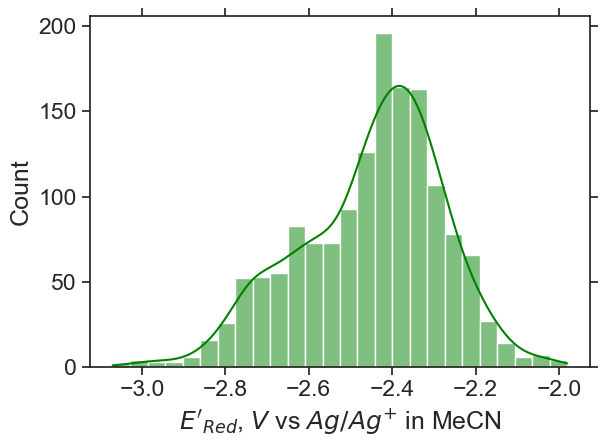

In [446]:
folder_path="./df_stats_1500/"
plot_one(df=df22,descriptor="Ered_ag", filename=folder_path+"ERed_1530mols.png")

# Shapiro-Wilk test for normality

In [376]:
from scipy.stats import shapiro

#get stats
data=df22.Ered_ag
stat,p = shapiro(data)

print(f"stat={stat:0.3f} and p={p:0.3f}")
if p > 0.05:
    print("we fail to reject the null hypothesis i.e. we assume the distribution of our variable is normal/gaussian")
else:
    print("we reject the null hypothesis i.e. we assume the distribution of our variable is not normal/gaussian")

stat=0.981 and p=0.000
we reject the null hypothesis i.e. we assume the distribution of our variable is not normal/gaussian


# Ered is not normally distributed

# Clean descriptors dataframe

In [377]:
df22_rdkit=data_cleaning(df=df22_rdkit)

Removing 0 columns with nan, if any
Before: df.shape=(1500, 125)
After: df.shape=(1500, 125) 

removing 0 duplicate columns, if any
Before: df.shape=(1500, 125)
After: df.shape=(1500, 125) 

removing 79 columns values with a unique value
Before: df.shape=(1500, 125)
After: df.shape=(1500, 46) 

returning a clean df


In [378]:
df22_rdkit.columns

Index(['sssr', 'clogp', 'mr', 'mw', 'tpsa', 'chi0n', 'chi1n', 'chi2n', 'chi3n',
       'chi4n', 'chi0v', 'chi1v', 'chi2v', 'chi3v', 'chi4v', 'fracsp3',
       'hall_kier_alpha', 'kappa1', 'kappa2', 'kappa3', 'labuteasa',
       'number_aliphatic_rings', 'number_atom_stereocenters',
       'number_bridgehead_atoms', 'number_HBA', 'number_HBD',
       'number_hetero_atoms', 'number_hetero_cycles', 'number_rings',
       'number_rotatable_bonds', 'number_saturated_rings',
       'number_heavy_atoms', 'number_nh_oh', 'number_n_o',
       'number_valence_electrons', 'max_partial_charge', 'min_partial_charge',
       'fr_methoxy', 'fr_ether', 'fr_NH1', 'fr_NH0', 'fr_aniline',
       'fr_unbrch_alkane', 'fr_bicyclic', 'fr_aryl_methyl',
       'fr_Ndealkylation1'],
      dtype='object')

# Scale descriptors before the PCA

In [379]:
df22_rdkit_st=do_scaling(xtrain=df22_rdkit)

test data is not provided, returning only scaled train data


In [380]:
df22_rdkit_st.head()

,sssr,clogp,mr,mw,tpsa,chi0n,chi1n,chi2n,chi3n,chi4n,chi0v,chi1v,chi2v,chi3v,chi4v,fracsp3,hall_kier_alpha,kappa1,kappa2,kappa3,labuteasa,number_aliphatic_rings,number_atom_stereocenters,number_bridgehead_atoms,number_HBA,number_HBD,number_hetero_atoms,number_hetero_cycles,number_rings,number_rotatable_bonds,number_saturated_rings,number_heavy_atoms,number_nh_oh,number_n_o,number_valence_electrons,max_partial_charge,min_partial_charge,fr_methoxy,fr_ether,fr_NH1,fr_NH0,fr_aniline,fr_unbrch_alkane,fr_bicyclic,fr_aryl_methyl,fr_Ndealkylation1
0,0.114226,-0.988864,1.342330,1.183302,-0.607929,1.325617,0.869606,1.209848,0.831464,0.476865,1.325617,0.869606,1.209848,0.836235,0.507497,0.912233,-0.298394,1.307263,1.071688,1.258266,1.214673,0.114226,-0.668019,-0.325875,1.170015,-0.739016,1.108442,0.689579,0.114226,0.314067,-0.325875,1.173518,-0.739016,1.108442,1.219022,-1.010183,0.619992,-0.482367,-0.975980,-0.739016,2.546709,0.963673,-0.192072,-0.214816,0.806758,3.436049
1,0.114226,-0.453665,1.151228,1.213808,0.005766,1.122828,0.927760,0.536193,0.824164,0.646174,1.122828,0.927760,0.536193,0.828925,0.675892,0.912233,-0.298394,1.307263,1.492812,1.018790,1.169265,0.114226,-0.668019,-0.325875,1.170015,-0.739016,1.108442,0.689579,0.114226,1.002812,-0.325875,1.173518,-0.739016,1.108442,1.219022,-1.010183,0.519448,1.683952,0.198014,-0.739016,1.421838,0.963673,-0.192072,-0.214816,0.806758,1.501337
2,0.114226,0.104502,1.448191,1.183302,0.292635,1.278583,1.052932,0.979723,0.670725,0.534172,1.278583,1.052932,0.979723,0.675261,0.505377,0.912233,-1.160805,1.222422,0.962241,0.685140,1.199921,0.114226,-0.668019,-0.325875,1.170015,1.272824,1.108442,0.689579,0.114226,0.314067,-0.325875,1.173518,1.272824,1.108442,1.219022,-0.446523,0.529034,-0.482367,-0.975980,1.272824,1.421838,1.968197,-0.192072,-0.214816,-0.791838,1.501337
3,0.114226,0.545938,1.878332,1.617814,0.292635,1.610987,1.692886,0.833109,0.877655,0.884106,1.610987,1.692886,0.833109,0.882493,0.853420,1.252553,-1.160805,1.753632,2.105264,1.703472,1.647118,0.114226,-0.668019,-0.325875,1.170015,1.272824,1.108442,0.689579,0.114226,1.691556,-0.325875,1.604430,1.272824,1.108442,1.670697,-0.446527,0.529032,-0.482367,-0.975980,1.272824,1.421838,1.968197,-0.192072,-0.214816,-0.791838,1.501337
4,0.114226,0.544134,1.876292,1.617814,0.292635,1.710675,1.589947,1.142998,0.963097,0.858748,1.710675,1.589947,1.142998,0.968061,0.828199,1.252553,-1.160805,1.753632,1.656869,1.459514,1.647118,0.114226,-0.668019,-0.325875,1.170015,1.272824,1.108442,0.689579,0.114226,1.002812,-0.325875,1.604430,1.272824,1.108442,1.670697,-0.446523,0.529034,-0.482367,-0.975980,1.272824,1.421838,1.968197,-0.192072,-0.214816,-0.791838,1.501337


# PCA

In [381]:
df22_rdkit_st.isna().any().sum()

0

C:\Users\jaina\AppData\Roaming\Python\Python37\site-packages\matplotlib\cbook\__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


No. of PC           Cumulative variance                                                             
--------------------------------------------------
1                   0.430795                                                                        
2                   0.606965                                                                        
3                   0.714537                                                                        
4                   0.784025                                                                        
5                   0.845733                                                                        
6                   0.872469                                                                        
7                   0.898407                                                                        
8                   0.919860                                                                        
9                   0.938597            

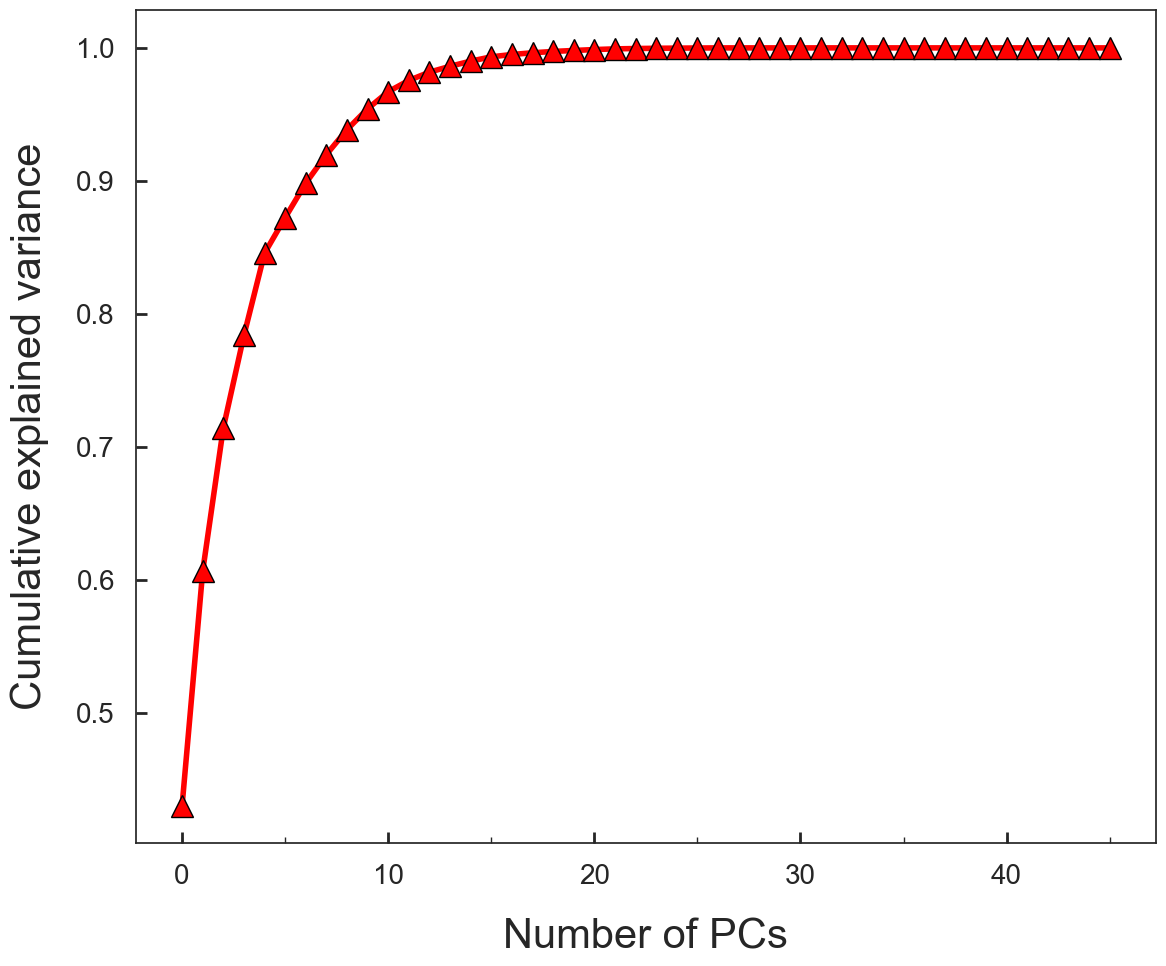

In [382]:
from sklearn.decomposition import PCA # Principle component analysis
import matplotlib.pyplot as plt  
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter, AutoMinorLocator)

X=df22_rdkit_st # scaled data

pca = PCA().fit(X)

#Plotting
fig, ax1 = plt.subplots()
ax1.set_xlabel('Number of PCs', fontsize=30,labelpad=20)
ax1.set_ylabel('Cumulative explained variance', fontsize=30,labelpad=20)
ax1.xaxis.set_major_locator(MultipleLocator(10))
ax1.xaxis.set_minor_locator(MultipleLocator(5))
ax1.tick_params(axis='both', which='major', direction='in', size=8, left='on', bottom='on', width=2, pad=15)
ax1.tick_params(axis='both', which='minor', direction='in', size=4, left='on', bottom='on',width=1, pad=15)
ax1.tick_params(axis="y", labelsize=20)
ax1.tick_params(axis="x", labelsize=20)

plt.gcf().set_size_inches((12, 10))
evr = np.cumsum(pca.explained_variance_ratio_)
ax1.plot(evr, marker='^',markersize=16, markeredgecolor='black', 
         linestyle='-',linewidth=4, color='red')   # Plotting
plt.tight_layout()
plt.savefig("./df_stats_1500/"+"pca_1530.png",dpi=300)
print('{:<20s}{:<80s}'.format('No. of PC','Cumulative variance'))
print(50*'-')
for i,a in enumerate(evr):
    if a<=1:
        print('{:<20d}{:<80f}'.format(i+1,a))

# Use 16 PCs

In [383]:
n_PC = 16  # Set number of principle components
pca = PCA(n_components=n_PC)
Xdata = pca.fit_transform(df22_rdkit_st)  # Transform feature vectors to PCs

# Plot PC1 and PC2 heatmap with Ered_ag

In [384]:
col_txt=["PC"+str(i+1) for i in np.arange(n_PC)]
df_xdata=pd.DataFrame(Xdata,columns=col_txt)
df_xdata.head()

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12,PC13,PC14,PC15,PC16
0,-4.864973,1.711644,-2.867232,-2.421849,-1.867013,-0.098177,1.626867,1.076169,0.207776,1.106132,-1.284101,0.506324,-0.317801,0.190024,-0.097704,1.201374
1,-4.325267,1.882069,-2.296519,-0.394120,-2.027235,1.016636,0.957526,-0.736861,0.927072,0.559252,-0.730603,-0.585718,-0.726447,0.202958,-0.693485,0.680105
2,-4.909534,3.162543,-1.009166,-2.256855,1.222933,0.118834,0.002267,0.015082,-0.257687,-0.057014,-0.492297,-0.095828,0.202099,-0.036685,0.396830,-0.042999
3,-6.661195,3.542839,-2.035278,-1.217179,1.546467,-0.062961,-0.226353,0.129639,-0.181683,-0.237735,-0.739001,-0.240639,-0.459737,0.280420,-0.429153,-0.476335
4,-6.636606,3.355973,-1.741389,-1.591506,1.386980,-0.162473,-0.172977,0.018080,-0.166923,-0.151848,-0.659410,-0.321693,-0.035217,0.108757,0.153048,-0.229458


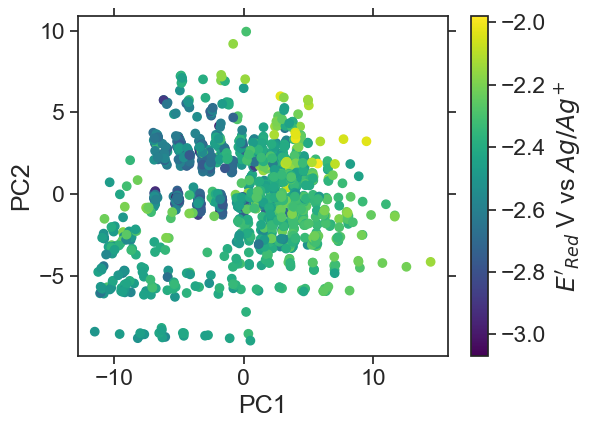

In [444]:
from cProfile import label
from turtle import position

plt.tick_params(reset=True)
plt.scatter(x=df_xdata.PC1,y=df_xdata.PC2,c=df22.Ered_ag,cmap="viridis")
plt.xlabel("PC1")
plt.ylabel("PC2")
# plt.title("E\'red",loc='right')
#set font of all elements to size 15
plt.rc('font', size=24) 
plt.colorbar(label="$E\'_{Red}$ V vs $Ag/Ag^{+}$")
# plt.legend()
plt.tight_layout()

plt.savefig("./df_stats_1500/"+"PC1_PC2_ERed_Ag_1530.png",dpi=300)

# Base model

# GPytorch model

In [386]:
import torch, gpytorch
from sklearn.metrics import mean_squared_error as MSE
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error as MAE
from sklearn.model_selection import train_test_split

In [387]:
def gpregression_pytorch(X_train,y_train,num_iter=200,learning_rate=0.1,verbose=False):
    
    """
    Gaussian Process Regression implementation with the GPyTorch
    
    Input: gpregression_pytorch(X_train,y_train,num_iter,learning_rate)
    
    Retrun: trained_model, trained_likelihood

    """
    # nfeatures=X_train.shape[1]
    train_x=torch.from_numpy(np.array(X_train))
    train_y=torch.from_numpy(np.array(y_train))
    torch.set_default_dtype(torch.float64)

    # We will use the simplest form of GP model, exact inference
    class ExactGPModel(gpytorch.models.ExactGP):

        def __init__(self, train_x, train_y, likelihood):
            super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
            self.mean_module = gpytorch.means.ConstantMean()
 
            self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.MaternKernel(nu=1.5))
        
        def forward(self, x):
            mean_x = self.mean_module(x)
            covar_x = self.covar_module(x)
            return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

    # initialize likelihood and model
    likelihood = gpytorch.likelihoods.GaussianLikelihood()
    model = ExactGPModel(train_x, train_y, likelihood)

    # this is for running the notebook in our testing framework
    import os
    smoke_test = ('CI' in os.environ)
    training_iter = 2 if smoke_test else num_iter


    # Find optimal model hyperparameters
    model.train()
    likelihood.train()

    # Use the adam optimizer # for hyperparameter tuning
    optimizer = torch.optim.Adam([
        {'params': model.parameters()},  # Includes GaussianLikelihood parameters
    ], lr=learning_rate)

    # "Loss" for GPs - the marginal log likelihood
    mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

    for i in range(training_iter):
        # Zero gradients from previous iteration
        optimizer.zero_grad()
        # Output from model
        output = model(train_x)
        # Calc loss and backprop gradients
        loss = -mll(output, train_y)
        loss.backward()
        if verbose*1*((i+1)%50==0 or i==0):
            print('Iter %d/%d - Loss: %.3f   lengthscale: %.3f   noise: %.3f' % (i + 1, training_iter, loss.item(),model.covar_module.base_kernel.lengthscale.item(),model.likelihood.noise.item()))
            # print('Iter %d/%d - Loss: %.3f    noise: %.3f' % (i + 1, training_iter, loss.item(),model.likelihood.noise.item()))
        optimizer.step()

    # Get into evaluation (predictive posterior) mode
    model.eval()
    likelihood.eval()

    return model,likelihood

def gprediction_pytorch(model,likelihood,X_test):
    
    """
    Gaussian Process Predictions with gpr_pytorch
    
    Use: 
    model, likelihood = gpregression_pytorch(X_train,y_train,num_iter=200,learning_rate=0.1)  
    ypred, ysigma = gprediction__pytorch(model,likelihood,X_test)

    Return: ypred and ysigma numpy arrays
    
    """
    # Get into evaluation (predictive posterior) mode
    model.eval()
    likelihood.eval()
    # Make predictions by feeding model through likelihood
    with torch.no_grad(), gpytorch.settings.fast_pred_var():
        test_x = torch.from_numpy(np.array(X_test))
        torch.set_default_dtype(torch.float64)
        observed_pred = likelihood(model(test_x))
        ypred = observed_pred.mean.numpy()
        ysigma = observed_pred.stddev.numpy()
    return ypred,ysigma

In [388]:
def gpr_one_pytorch(X,y,train_pc=0.8):
    # use X after scalling and pca
    X_train, X_test, y_train, y_test = train_test_split(X,y,train_size=train_pc) 

    
    model, likelihood = gpregression_pytorch(X_train,y_train,verbose=False)
    
    ypred_test, yerr_test = gprediction_pytorch(model,likelihood,X_test)
    ypred_train, yerr_train = gprediction_pytorch(model,likelihood,X_train)
    
    return y_test,ypred_test,yerr_test,y_train, ypred_train, yerr_train

In [442]:
def plot_Ered_gpr(y_true_train,y_pred_train,y_true_test,y_pred_test,y_pred_err_train=None,y_pred_err_test=None,err_bar=False,showfig=True,savefig=False,filename="gpr_pred.png",data=True):
    """
    Return r2,rmse and mae score if data = True
    Show image if showfig=True
    Save image if savefig=True
    """
    
    mae_train = round(MAE(y_true_train,y_pred_train),2)
    r2_train = round(r2_score(y_true_train,y_pred_train),2)
    rmse_train = round(np.sqrt(MSE(y_true_train,y_pred_train)),2)

    mae_test = round(MAE(y_true_test,y_pred_test),2)
    r2_test = round(r2_score(y_true_test,y_pred_test),2)
    rmse_test = round(np.sqrt(MSE(y_true_test,y_pred_test)),2)

    # print(f"(Train: R2 = %0.2f, RMSE = %0.2f, MAE = %0.2f)" %(r2_train,rmse_train,mae_train))    
    # print(f"(Test:  R2 = %0.2f, RMSE = %0.2f, MAE = %0.2f)" %(r2_test,rmse_test,mae_test))    
    #set font of all elements to size 15
     
    if showfig:
        plt.figure(figsize=(6, 6)) 
        plt.tick_params(reset=True)
        # plt.scatter(y_true,y_pred,color=color,label=label)
        if err_bar*(y_pred_err_train is not None):
            plt.errorbar(y_true_train,y_pred_train,yerr=y_pred_err_train,color="red",fmt='o',label="Train")

        if err_bar*(y_pred_err_test is not None):
            plt.errorbar(y_true_test,y_pred_test,yerr=y_pred_err_test,color="blue",fmt='o',label="Test")

        plt.plot([y_true_train.min()-0.2,y_true_train.max()+0.2],[y_true_train.min()-0.2,y_true_train.max()+0.2],color='black')
        
        string=f"$R^2$={r2_train:0.2f}, RMSE = {rmse_train:0.2f}"
        plt.text(y_true_train.min()-0.1,y_true_train.max()-0.03,string,color='red')
        # string=f" (train) = {rmse_train:0.2f}"
        # plt.text(y_true_train.min(),y_true_train.max()-0.23,string)
        
        # string=f"$R^2$ (test) = {r2_test:0.2f}"
        string=f"$R^2$={r2_test:0.2f}, RMSE = {rmse_test:0.2f}"
        plt.text(y_true_train.min()-0.1,y_true_train.max()-0.15,string,color="blue")
        # plt.text(0.75,1.60,string)
        # string=f"RMSE (test)= {rmse_test:0.2f}"
        # plt.text(y_true_train.min(),y_true_train.max()-0.35,string)
        # plt.text(0.75,1.55,string)
        plt.rc('font', size=20)
        plt.xlabel('DFT calculated values (V)')
        plt.ylabel('GPR Predicted values (V)')
        plt.xlim([y_true_train.min()-0.1,y_true_train.max()+0.1])
        plt.ylim([y_true_train.min()-0.1,y_true_train.max()+0.1])
        plt.xticks(np.arange(y_true_train.min()-0.1,y_true_train.max()+0.1,0.4))        
        plt.yticks(np.arange(y_true_train.min()-0.1,y_true_train.max()+0.1,0.4))
        # plt.xticks(np.arange(0.7,2,0.2))
        plt.legend(loc='lower right') #best
        plt.tight_layout()
        # print("Train: min error =", round(y_pred_err_train.min(),2),"max_err", round(y_pred_err_train.max(),2))
        # print("Test: min error =", round(y_pred_err_test.min(),2),"max_err", round(y_pred_err_test.max(),2))
        if savefig:
            plt.savefig(filename,dpi=300,bbox_inches='tight')
        plt.show()


    if data:
        return r2_test,rmse_test,mae_test,r2_train,rmse_train,mae_train

# Learning curves for Number of PCs

In [392]:
def gpr_one_pca_pytorch(X,y,train_pc=0.8,nPC=5,random_state=None):

    X_train, X_test, y_train, y_test = train_test_split(X,y,train_size=train_pc,random_state=random_state) 

    xtrain, xtest = do_scaling(scaler=StandardScaler(),xtrain=X_train, xtest=X_test)
    # PCA
    n_PC = nPC  # Set number of principle components
    pca = PCA(n_components=n_PC)
        
    xtrain = pca.fit_transform(xtrain) 
    xtest=pca.transform(xtest)
    # print(f"xtrain.shape={xtrain.shape},xtest.shape={xtest.shape}")
    model, likelihood = gpregression_pytorch(xtrain,y_train,verbose=False)
    
    ypred_test, yerr_test = gprediction_pytorch(model,likelihood,xtest)
    ypred_train, yerr_train = gprediction_pytorch(model,likelihood,xtrain)
    
    return y_test,ypred_test,yerr_test,y_train, ypred_train, yerr_train

In [393]:
def helper(X,y,nPC=5,train_pc=0.8,random_state=None):
    y_test,ypred_test,yerr_test,y_train, ypred_train, yerr_train=gpr_one_pca_pytorch(X=X,y=y,train_pc=train_pc,nPC=nPC,random_state=random_state)
    r2_test,rmse_test,mae_test,r2_train,rmse_train,mae_train=plot_Ered_gpr(y_true_train=y_train,y_pred_train=ypred_train,y_true_test=y_test,y_pred_test=ypred_test,y_pred_err_train=yerr_train,y_pred_err_test=yerr_test,err_bar=True,showfig=False,savefig=False,data=True)
    return r2_test,rmse_test,mae_test,r2_train,rmse_train,mae_train

In [394]:
train_pcs=np.arange(0.1,1,0.1)
num_PCs = [4, 8, 16, 32, df22_rdkit_st.shape[1]]

In [395]:
num_PCs

[4, 8, 16, 32, 46]

In [396]:
train_pcs_avg_train_score=np.zeros([len(train_pcs),len(num_PCs),3])
train_pcs_avg_test_score=np.zeros([len(train_pcs),len(num_PCs),3])
train_pcs_std_train_score=np.zeros([len(train_pcs),len(num_PCs),3])
train_pcs_std_test_score=np.zeros([len(train_pcs),len(num_PCs),3])

# Be patient next block of code will take hours to complete

In [ ]:
repeats=50
for jdx,tr_pc in enumerate(train_pcs):
    print("-"*10)
    print(f" tr_pc = {tr_pc} \n")

    avg_train_score = np.zeros([len(num_PCs),3])
    avg_test_score = np.zeros([len(num_PCs),3])

    std_train_score = np.zeros([len(num_PCs),3])
    std_test_score = np.zeros([len(num_PCs),3])

    for idx,PCs in enumerate(num_PCs):
        print("+"*10)
        print(f"--> PCs={PCs}, nPCs={num_PCs} <--")
        # split train and test datasets
        X=df22_rdkit
        y=df22.Ered_ag.to_list()
        
        
        r2_train,rmse_train,mae_train=np.zeros(repeats),np.zeros(repeats),np.zeros(repeats)
        r2_test,rmse_test,mae_test=np.zeros(repeats),np.zeros(repeats),np.zeros(repeats)

        for j in np.arange(repeats):
            print(f" ---> %repeat <-- ={100*j/repeats}")
            r2_test[j],rmse_test[j],mae_test[j],r2_train[j],rmse_train[j],mae_train[j]=helper(X=X,y=y,nPC=PCs,train_pc=tr_pc)

        avg_test_score[idx] = r2_test.mean(),rmse_test.mean(),mae_test.mean()
        avg_train_score[idx] = r2_train.mean(),rmse_train.mean(),mae_train.mean()
        std_test_score[idx] = r2_test.std(),rmse_test.std(),mae_test.std()
        std_train_score[idx] = r2_train.std(),rmse_train.std(),mae_train.std()

    # store scores for each tr_pc
    train_pcs_avg_train_score[jdx] = avg_train_score
    train_pcs_avg_test_score[jdx] = avg_test_score
    train_pcs_std_train_score[jdx] = std_train_score
    train_pcs_std_test_score[jdx] = std_test_score

# Plot Learning curves

In [404]:
train_pcs

array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9])

In [406]:
y_r2_avg_tr_10_4pc=[train_pcs_avg_train_score[x][0][0] for x in np.arange(len(train_pcs))]
y_rmse_avg_tr_10_4pc=[train_pcs_avg_train_score[x][0][1] for x in np.arange(len(train_pcs))]
y_mae_avg_tr_10_4pc=[train_pcs_avg_train_score[x][0][2] for x in np.arange(len(train_pcs))]

y_r2_std_tr_10_4pc=[train_pcs_std_train_score[x][0][0] for x in np.arange(len(train_pcs))]
y_rmse_std_tr_10_4pc=[train_pcs_std_train_score[x][0][1] for x in np.arange(len(train_pcs))]
y_mae_std_tr_10_4pc=[train_pcs_std_train_score[x][0][2] for x in np.arange(len(train_pcs))]

y_r2_avg_tr_10_8pc=[train_pcs_avg_train_score[x][1][0] for x in np.arange(len(train_pcs))]
y_rmse_avg_tr_10_8pc=[train_pcs_avg_train_score[x][1][1] for x in np.arange(len(train_pcs))]
y_mae_avg_tr_10_8pc=[train_pcs_avg_train_score[x][1][2] for x in np.arange(len(train_pcs))]

y_r2_std_tr_10_8pc=[train_pcs_std_train_score[x][1][0] for x in np.arange(len(train_pcs))]
y_rmse_std_tr_10_8pc=[train_pcs_std_train_score[x][1][1] for x in np.arange(len(train_pcs))]
y_mae_std_tr_10_8pc=[train_pcs_std_train_score[x][1][2] for x in np.arange(len(train_pcs))]

y_r2_avg_tr_10_16pc=[train_pcs_avg_train_score[x][2][0] for x in np.arange(len(train_pcs))]
y_rmse_avg_tr_10_16pc=[train_pcs_avg_train_score[x][2][1] for x in np.arange(len(train_pcs))]
y_mae_avg_tr_10_16pc=[train_pcs_avg_train_score[x][2][2] for x in np.arange(len(train_pcs))]

y_r2_std_tr_10_16pc=[train_pcs_std_train_score[x][2][0] for x in np.arange(len(train_pcs))]
y_rmse_std_tr_10_16pc=[train_pcs_std_train_score[x][2][1] for x in np.arange(len(train_pcs))]
y_mae_std_tr_10_16pc=[train_pcs_std_train_score[x][2][2] for x in np.arange(len(train_pcs))]

y_r2_avg_tr_10_32pc=[train_pcs_avg_train_score[x][3][0] for x in np.arange(len(train_pcs))]
y_rmse_avg_tr_10_32pc=[train_pcs_avg_train_score[x][3][1] for x in np.arange(len(train_pcs))]
y_mae_avg_tr_10_32pc=[train_pcs_avg_train_score[x][3][2] for x in np.arange(len(train_pcs))]

y_r2_std_tr_10_32pc=[train_pcs_std_train_score[x][3][0] for x in np.arange(len(train_pcs))]
y_rmse_std_tr_10_32pc=[train_pcs_std_train_score[x][3][1] for x in np.arange(len(train_pcs))]
y_mae_std_tr_10_32pc=[train_pcs_std_train_score[x][3][2] for x in np.arange(len(train_pcs))]

y_r2_avg_tr_10_46pc=[train_pcs_avg_train_score[x][4][0] for x in np.arange(len(train_pcs))]
y_rmse_avg_tr_10_46pc=[train_pcs_avg_train_score[x][4][1] for x in np.arange(len(train_pcs))]
y_mae_avg_tr_10_46pc=[train_pcs_avg_train_score[x][4][2] for x in np.arange(len(train_pcs))]

y_r2_std_tr_10_46pc=[train_pcs_std_train_score[x][4][0] for x in np.arange(len(train_pcs))]
y_rmse_std_tr_10_46pc=[train_pcs_std_train_score[x][4][1] for x in np.arange(len(train_pcs))]
y_mae_std_tr_10_46pc=[train_pcs_std_train_score[x][4][2] for x in np.arange(len(train_pcs))]


In [407]:
# plt.style.use("default")

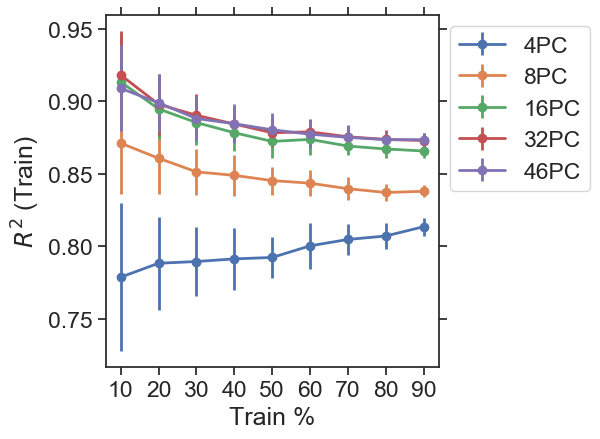

In [408]:
plt.tick_params(reset=True)
# plt.rcParams['ytick.labelsize'] = 25
# plt.rc('font', size=20) 
# plt.figure(figsize=(4,6))
plt.errorbar(x=100*train_pcs,y=y_r2_avg_tr_10_4pc,yerr=y_r2_std_tr_10_4pc,label="4PC",fmt='-o',linewidth=2)
plt.errorbar(100*train_pcs,y_r2_avg_tr_10_8pc,yerr=y_r2_std_tr_10_8pc,fmt='-o',label="8PC",linewidth=2)
plt.errorbar(100*train_pcs,y_r2_avg_tr_10_16pc,yerr=y_r2_std_tr_10_16pc,fmt='-o',label="16PC",linewidth=2)
plt.errorbar(100*train_pcs,y_r2_avg_tr_10_32pc,yerr=y_r2_std_tr_10_32pc,fmt='-o',label="32PC",linewidth=2)
plt.errorbar(100*train_pcs,y_r2_avg_tr_10_46pc,yerr=y_r2_std_tr_10_46pc,fmt='-o',label="46PC",linewidth=2)
plt.rc('font', size=20) 
plt.xlabel("Train %")
plt.ylabel("$R^{2}$ (Train)")
plt.xticks(100*train_pcs)
# plt.legend(l)
plt.legend(bbox_to_anchor=(1,1), loc="upper left")
plt.tight_layout()
plt.savefig(r"./df_stats_1500/r2_train_learning_curve_train_test_pcs.png",dpi=300)

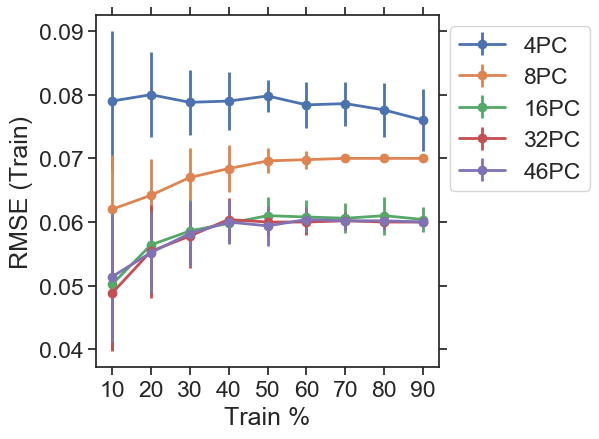

In [428]:
plt.tick_params(reset=True)
plt.errorbar(x=100*train_pcs,y=y_rmse_avg_tr_10_4pc,yerr=y_rmse_std_tr_10_4pc,label="4PC",fmt='-o',linewidth=2)
plt.errorbar(100*train_pcs,y_rmse_avg_tr_10_8pc,yerr=y_rmse_std_tr_10_8pc,fmt='-o',label="8PC",linewidth=2)
plt.errorbar(100*train_pcs,y_rmse_avg_tr_10_16pc,yerr=y_rmse_std_tr_10_16pc,fmt='-o',label="16PC",linewidth=2)
plt.errorbar(100*train_pcs,y_rmse_avg_tr_10_32pc,yerr=y_rmse_std_tr_10_32pc,fmt='-o',label="32PC",linewidth=2)
plt.errorbar(100*train_pcs,y_rmse_avg_tr_10_46pc,yerr=y_rmse_std_tr_10_46pc,fmt='-o',label="46PC",linewidth=2)

plt.rc('font', size=20) 
plt.xlabel("Train %")
plt.ylabel("RMSE (Train)")
plt.xticks(100*train_pcs)
# plt.legend(loc='best')
plt.legend(bbox_to_anchor=(1,1), loc="upper left")
plt.tight_layout()
plt.savefig(r"./df_stats_1500/rmse_train_learning_curve_train_test_pcs.png",dpi=300)

In [410]:
# save numpy array as npy file
from numpy import asarray
from numpy import save
# define data
# data = asarray([[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]])

In [411]:

# # save to npy file
# save(r'./Data/1500_learning_curve_data/train_pcs_avg_test_score.npy', train_pcs_avg_test_score)
# save(r'./Data/1500_learning_curve_data/train_pcs_avg_train_score.npy', train_pcs_avg_train_score)
# save(r'./Data/1500_learning_curve_data/train_pcs_std_test_score.npy', train_pcs_std_test_score)
# save(r'./Data/1500_learning_curve_data/train_pcs_std_train_score.npy', train_pcs_std_train_score)

In [412]:
# # load numpy array from npy file
# from numpy import load
# # load array
# data = load(r'./Data/1500_learning_curve_data/train_pcs_avg_test_score.npy')
# # print the array
# print(data)

In [413]:
y_r2_avg_ts_10_4pc=[train_pcs_avg_test_score[x][0][0] for x in np.arange(len(train_pcs))]
y_rmse_avg_ts_10_4pc=[train_pcs_avg_test_score[x][0][1] for x in np.arange(len(train_pcs))]
y_mae_avg_ts_10_4pc=[train_pcs_avg_test_score[x][0][2] for x in np.arange(len(train_pcs))]

y_r2_std_ts_10_4pc=[train_pcs_std_test_score[x][0][0] for x in np.arange(len(train_pcs))]
y_rmse_std_ts_10_4pc=[train_pcs_std_test_score[x][0][1] for x in np.arange(len(train_pcs))]
y_mae_std_ts_10_4pc=[train_pcs_std_test_score[x][0][2] for x in np.arange(len(train_pcs))]

y_r2_avg_ts_10_8pc=[train_pcs_avg_test_score[x][1][0] for x in np.arange(len(train_pcs))]
y_rmse_avg_ts_10_8pc=[train_pcs_avg_test_score[x][1][1] for x in np.arange(len(train_pcs))]
y_mae_avg_ts_10_8pc=[train_pcs_avg_test_score[x][1][2] for x in np.arange(len(train_pcs))]

y_r2_std_ts_10_8pc=[train_pcs_std_test_score[x][1][0] for x in np.arange(len(train_pcs))]
y_rmse_std_ts_10_8pc=[train_pcs_std_test_score[x][1][1] for x in np.arange(len(train_pcs))]
y_mae_std_ts_10_8pc=[train_pcs_std_test_score[x][1][2] for x in np.arange(len(train_pcs))]

y_r2_avg_ts_10_16pc=[train_pcs_avg_test_score[x][2][0] for x in np.arange(len(train_pcs))]
y_rmse_avg_ts_10_16pc=[train_pcs_avg_test_score[x][2][1] for x in np.arange(len(train_pcs))]
y_mae_avg_ts_10_16pc=[train_pcs_avg_test_score[x][2][2] for x in np.arange(len(train_pcs))]

y_r2_std_ts_10_16pc=[train_pcs_std_test_score[x][2][0] for x in np.arange(len(train_pcs))]
y_rmse_std_ts_10_16pc=[train_pcs_std_test_score[x][2][1] for x in np.arange(len(train_pcs))]
y_mae_std_ts_10_16pc=[train_pcs_std_test_score[x][2][2] for x in np.arange(len(train_pcs))]

y_r2_avg_ts_10_32pc=[train_pcs_avg_test_score[x][3][0] for x in np.arange(len(train_pcs))]
y_rmse_avg_ts_10_32pc=[train_pcs_avg_test_score[x][3][1] for x in np.arange(len(train_pcs))]
y_mae_avg_ts_10_32pc=[train_pcs_avg_test_score[x][3][2] for x in np.arange(len(train_pcs))]

y_r2_std_ts_10_32pc=[train_pcs_std_test_score[x][3][0] for x in np.arange(len(train_pcs))]
y_rmse_std_ts_10_32pc=[train_pcs_std_test_score[x][3][1] for x in np.arange(len(train_pcs))]
y_mae_std_ts_10_32pc=[train_pcs_std_test_score[x][3][2] for x in np.arange(len(train_pcs))]

y_r2_avg_ts_10_46pc=[train_pcs_avg_test_score[x][4][0] for x in np.arange(len(train_pcs))]
y_rmse_avg_ts_10_46pc=[train_pcs_avg_test_score[x][4][1] for x in np.arange(len(train_pcs))]
y_mae_avg_ts_10_46pc=[train_pcs_avg_test_score[x][4][2] for x in np.arange(len(train_pcs))]

y_r2_std_ts_10_46pc=[train_pcs_std_test_score[x][4][0] for x in np.arange(len(train_pcs))]
y_rmse_std_ts_10_46pc=[train_pcs_std_test_score[x][4][1] for x in np.arange(len(train_pcs))]
y_mae_std_ts_10_46pc=[train_pcs_std_test_score[x][4][2] for x in np.arange(len(train_pcs))]


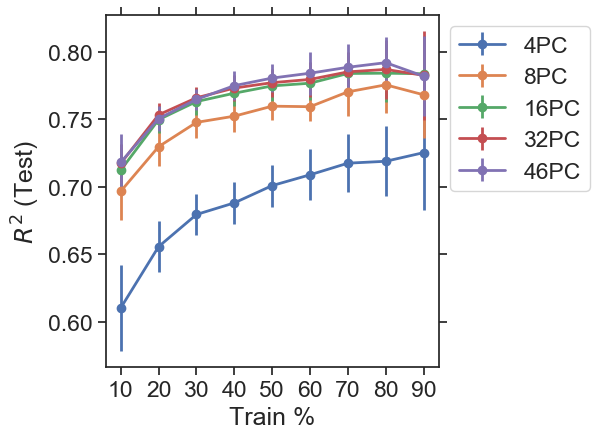

In [429]:
plt.tick_params(reset=True)
plt.errorbar(x=100*train_pcs,y=y_r2_avg_ts_10_4pc,yerr=y_r2_std_ts_10_4pc,label="4PC",fmt='-o',linewidth=2)
plt.errorbar(100*train_pcs,y_r2_avg_ts_10_8pc,yerr=y_r2_std_ts_10_8pc,fmt='-o',label="8PC",linewidth=2)
plt.errorbar(100*train_pcs,y_r2_avg_ts_10_16pc,yerr=y_r2_std_ts_10_16pc,fmt='-o',label="16PC",linewidth=2)
plt.errorbar(100*train_pcs,y_r2_avg_ts_10_32pc,yerr=y_r2_std_ts_10_32pc,fmt='-o',label="32PC",linewidth=2)
plt.errorbar(100*train_pcs,y_r2_avg_ts_10_46pc,yerr=y_r2_std_ts_10_46pc,fmt='-o',label="46PC",linewidth=2)
plt.rc('font', size=20) 
plt.xlabel("Train %")
plt.ylabel("$R^{2}$ (Test)")
plt.xticks(100*train_pcs)
# plt.legend(l)
plt.legend(bbox_to_anchor=(1,1), loc="upper left")
plt.tight_layout()
plt.savefig(r"./df_stats_1500/r2_test_learning_curve_train_test_pcs.png",dpi=300)

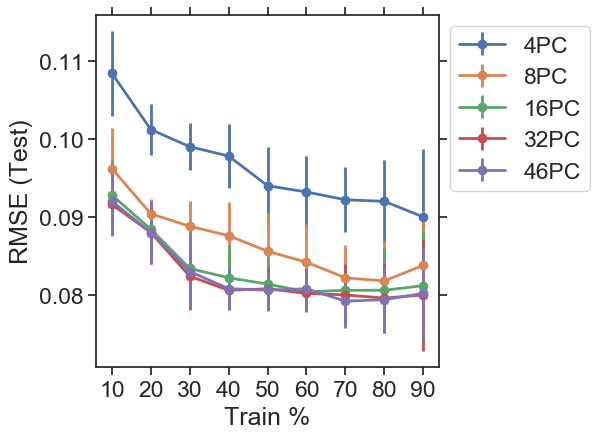

In [430]:
plt.tick_params(reset=True)
# plt.tick_params(axis='both',which='minor')
plt.errorbar(x=100*train_pcs,y=y_rmse_avg_ts_10_4pc,yerr=y_rmse_std_ts_10_4pc,label="4PC",fmt='-o',linewidth=2)
plt.errorbar(100*train_pcs,y_rmse_avg_ts_10_8pc,yerr=y_rmse_std_ts_10_8pc,fmt='-o',label="8PC",linewidth=2)
plt.errorbar(100*train_pcs,y_rmse_avg_ts_10_16pc,yerr=y_rmse_std_ts_10_16pc,fmt='-o',label="16PC",linewidth=2)
plt.errorbar(100*train_pcs,y_rmse_avg_ts_10_32pc,yerr=y_rmse_std_ts_10_32pc,fmt='-o',label="32PC",linewidth=2)
plt.errorbar(100*train_pcs,y_rmse_avg_ts_10_46pc,yerr=y_rmse_std_ts_10_46pc,fmt='-o',label="46PC",linewidth=2)

plt.rc('font', size=20) 
plt.xlabel("Train %")
plt.ylabel("RMSE (Test)")
plt.xticks(100*train_pcs)
# plt.legend(loc='best')
plt.legend(bbox_to_anchor=(1,1), loc="upper left")
plt.tight_layout()
plt.savefig(r"./df_stats_1500/rmse_test_learning_curve_train_test_pcs.png",dpi=300)

In [431]:
def plot_R2_learning_curve_num_PCs(num_PCs,avg_test_score,avg_train_score,std_test_score,std_train_score,filename="learning_r2.png"):
    plt.tick_params(reset=True)
    plt.plot(num_PCs,avg_train_score[:,0],"-o",label="train",color="blue")
    plt.plot(num_PCs,avg_test_score[:,0],"-o",label="test",color="red")

    plt.scatter(num_PCs,avg_train_score[:,0],color="blue")
    plt.scatter(num_PCs,avg_test_score[:,0],color="red")

    plt.errorbar(num_PCs,avg_train_score[:,0],yerr=std_train_score[:,0],color="blue")
    plt.errorbar(num_PCs,avg_test_score[:,0],yerr=std_test_score[:,0],color="red")

    plt.xlabel("Number of PCs")
    plt.ylabel("R$^2$")
    plt.legend()
    plt.xticks(num_PCs)
    plt.tight_layout()
    plt.savefig(filename,dpi=300)

In [432]:
train_pcs_avg_test_score[-2]

array([[0.7188, 0.092 , 0.0686],
       [0.7754, 0.0818, 0.0608],
       [0.784 , 0.0806, 0.0592],
       [0.7868, 0.0796, 0.0586],
       [0.7918, 0.0794, 0.0584]])

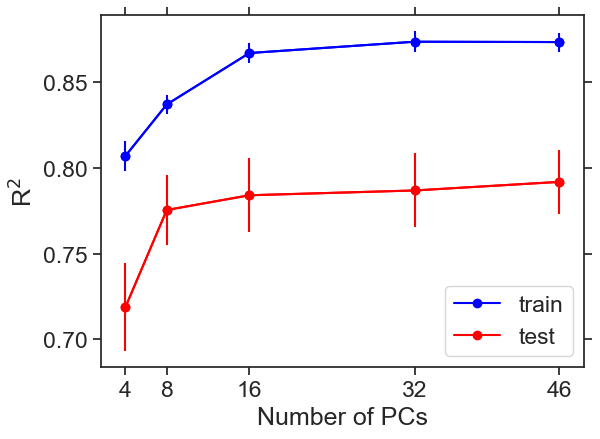

In [433]:
train_pc=-2
plot_R2_learning_curve_num_PCs(num_PCs=num_PCs,avg_test_score=train_pcs_avg_test_score[train_pc],avg_train_score=train_pcs_avg_train_score[train_pc],std_test_score=train_pcs_std_test_score[train_pc],std_train_score=train_pcs_std_train_score[train_pc],filename=r"./df_stats_1500/R2_learning_curve_test_split_80pc_training.png")

In [434]:
def plot_RMSE_learning_curve_num_PCs(num_PCs,avg_test_score,avg_train_score,std_test_score,std_train_score,filename="learning.png"):
    plt.tick_params(reset=True)
    plt.plot(num_PCs,avg_train_score[:,1],"-o",label="train",color="blue")
    plt.plot(num_PCs,avg_test_score[:,1],"-o",label="test",color="red")

    plt.scatter(num_PCs,avg_train_score[:,1],color="blue")
    plt.scatter(num_PCs,avg_test_score[:,1],color="red")

    plt.errorbar(num_PCs,avg_train_score[:,1],yerr=std_train_score[:,1],color="blue")
    plt.errorbar(num_PCs,avg_test_score[:,1],yerr=std_test_score[:,1],color="red")

    plt.xlabel("Number of PCs")
    plt.ylabel("RMSE")
    plt.legend()
    plt.xticks(num_PCs)
    plt.tight_layout()
    plt.savefig(filename,dpi=300)

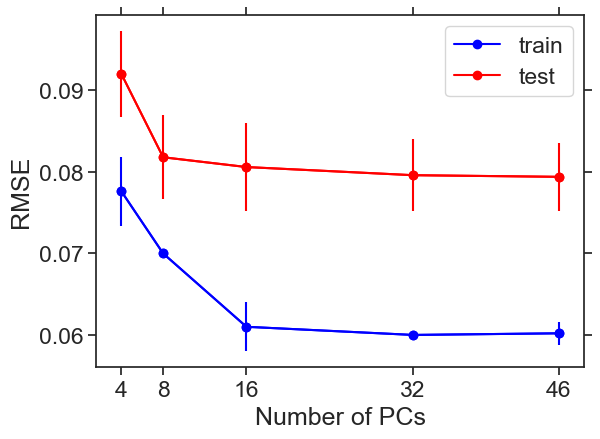

In [435]:
train_pc=-2
plot_RMSE_learning_curve_num_PCs(num_PCs=num_PCs,avg_test_score=train_pcs_avg_test_score[train_pc],avg_train_score=train_pcs_avg_train_score[train_pc],std_test_score=train_pcs_std_test_score[train_pc],std_train_score=train_pcs_std_train_score[train_pc],filename=r"./df_stats_1500/RMSE_learning_curve_test_split_80pc_training.png")

# The GPR model's RMSE/R2 doesn't imporve much with 32 and 46 (all) PCs (features) compared to the 16 PC case. Hence, it is reasonable to use 16 PCs to achieve both accuracy and efficiency 

In [437]:
# Use 16 PCs and 80-20% train-test split 
X=df_xdata  # df_xdata has 16 PCs
y=df22.Ered_ag
y_test,ypred_test,yerr_test,y_train, ypred_train, yerr_train=gpr_one_pytorch(X=X,y=y,train_pc=0.8)

c:\Users\jaina\Anaconda3\envs\myenv\lib\site-packages\gpytorch\models\exact_gp.py:275: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  GPInputWarning,


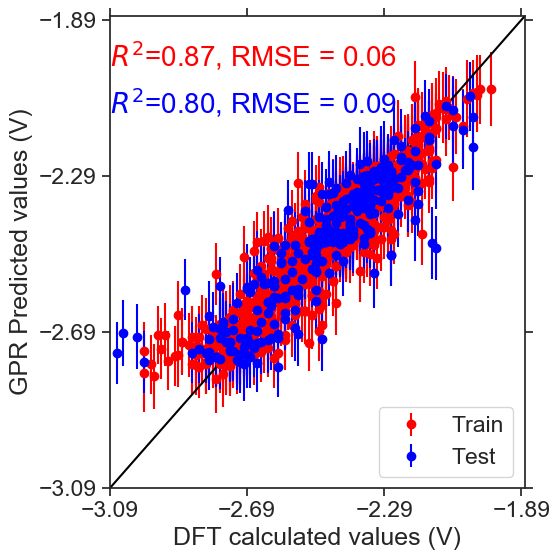

In [443]:
plot_Ered_gpr(y_true_train=y_train,y_pred_train=ypred_train,y_true_test=y_test,y_pred_test=ypred_test,y_pred_err_train=yerr_train,y_pred_err_test=yerr_test,err_bar=True,showfig=True,savefig=True,data=False,filename="./df_stats_1500/base_model_16PCs_8020_1530mols.png")

# Active Learning to find the molecule with lowest E'Red (V)

In [454]:
def expectedimprovement_pytorch(xdata,gp_model,gp_likelihood,ybest,itag,epsilon):
    from scipy.stats import norm
    ye_pred, esigma = gprediction_pytorch(model=gp_model,likelihood=gp_likelihood,X_test=xdata)
    expI = np.empty(ye_pred.size, dtype=float)
    for ii in range(0,ye_pred.size):
        if esigma[ii] > 0:
            zzval=itag*(ye_pred[ii]-ybest)/float(esigma[ii])
            expI[ii]=itag*(ye_pred[ii]-ybest-epsilon)*norm.cdf(zzval)+esigma[ii]*norm.pdf(zzval)
        else:
            expI[ii]=0.0
    return expI

def probabilityOfImprovement_pytorch(xdata,gp_model,gp_likelihood,ybest,epsilon):  
    "ybest: GPR-predicted best output property of the TRAINING set"
    from scipy.stats import norm
    ye_pred, esigma = gprediction_pytorch(model=gp_model,likelihood=gp_likelihood,X_test=xdata)
    poI = np.empty(ye_pred.size, dtype=float)
    for ii in range(0,ye_pred.size):
        if esigma[ii] > 0:
            zzval=(ye_pred[ii]-ybest-epsilon)/float(esigma[ii])
            poI[ii]=norm.cdf(zzval)
        else:
            poI[ii]=0.0
    return poI

# Acquisition functions
def upperConfidenceBound_pytorch(xdata,gp_model,gp_likelihood,epsilon):
    """
        xdata: input feature vectors or PCs of the REMAINING set
        gpnetwork: GPR model
        epsilon: control exploration/exploitation. Higher epsilon means more exploration
    """
    from scipy.stats import norm
    ye_pred, esigma = gprediction_pytorch(model=gp_model,likelihood=gp_likelihood,X_test=xdata)
    ucb = np.empty(ye_pred.size, dtype=float)
    for ii in range(0,ye_pred.size):
        if esigma[ii] > 0:
            ucb[ii]=(ye_pred[ii]+epsilon*esigma[ii])
        else:
            ucb[ii]=0.0
    return ucb

In [524]:
# X=df_xdata  # df_xdata has 16 PCs
Xdata=Xdata
Xsmiles = df22.smiles
# dfEox=df22.Ered_ag


In [525]:
from tqdm.auto import tqdm

In [543]:
def BayesOpt(Xdata,Ydata,Xinfo,ndata,nPC,eps,af,Niteration,filename):
    ntrain = 10 # Number of initial training data points
    nremain = ndata - ntrain
    dataset = np.random.permutation(ndata)
    a1data = np.empty(ntrain, dtype=int)
    a2data = np.empty(nremain, dtype=int)
    a1data[:] = dataset[0:ntrain]
    a2data[:] = dataset[ntrain:ndata]

    Xtrain = np.ndarray(shape=(ntrain, nPC), dtype=float)
    Xtraininfo = np.chararray(ntrain, itemsize=100)
    Ytrain = np.empty(ntrain, dtype=float)
    Xtrain[0:ntrain, :] = Xdata[a1data, :]
    Xtraininfo[0:ntrain] = Xinfo[a1data]
    Ytrain[0:ntrain] = Ydata[a1data]
    
    yoptLoc = np.argmax(Ytrain)
    yopttval = Ytrain[yoptLoc]

    xoptval = Xtraininfo[yoptLoc]
    yoptstep=0
    yopinit = yopttval
    xoptint = xoptval

    Xremain = np.ndarray(shape=(nremain, nPC), dtype=float)
    Xremaininfo = np.chararray(nremain, itemsize=100)
    Yremain = np.empty(nremain, dtype=float)
    Xremain[0:nremain, :] = Xdata[a2data, :]
    Xremaininfo[0:nremain] = Xinfo[a2data]
    Yremain[0:nremain] = Ydata[a2data]
    
    
    
    pfile = open(filename,'a+')
    pfile.write("batch,Iteration,SMILES,Ered \n")

    for i in range(ntrain):

        pfile.write(f'initial,{i},{Xtraininfo[i].decode()},{-Ytrain[i]:0.2f} \n')

    # print("Total number of inital training points: ", ntrain)
    print(f"Initial best SMILES is {xoptval.decode()} with Ered = {-yopttval:0.2f} V \n")
    
    for ii in tqdm(range(0, Niteration),desc='Progress'):
        model, likelihood = gpregression_pytorch(X_train=Xtrain,y_train=Ytrain,num_iter=350,learning_rate=0.05,verbose=False)
        yt_pred, tsigma = gprediction_pytorch(model,likelihood,X_test=Xtrain)
        
        ybestloc = np.argmax(Ytrain) # The current best y value
         
        ybest = yt_pred[ybestloc]
        ytrue = Ytrain[ybestloc]
                
        if yopttval < ytrue:
            yopttval = ytrue
            xoptval = Xtraininfo[ybestloc]
            
        if af=='EI':

            afValues = expectedimprovement_pytorch(xdata=Xremain, gp_model=model,gp_likelihood=likelihood, ybest=ybest, itag=1, epsilon=eps)
        elif af=='POI':

            afValues = probabilityOfImprovement_pytorch(xdata=Xremain, gp_model=model,gp_likelihood=likelihood, ybest=ybest, epsilon=eps)
        elif af=='UCB':

            afValues = upperConfidenceBound_pytorch(xdata=Xremain, gp_model=model,gp_likelihood=likelihood, psilon=eps)

        # afMax = np.max(afValues)
        afmaxloc = np.argmax(afValues)
        
        xnew = np.append(Xtrain, Xremain[afmaxloc]).reshape(-1, nPC)
        xnewinfo = np.append(Xtraininfo, Xremaininfo[afmaxloc])
        ynew = np.append(Ytrain, Yremain[afmaxloc])
        xrnew = np.delete(Xremain, afmaxloc, 0)
        xrnewinfo = np.delete(Xremaininfo, afmaxloc)
        yrnew = np.delete(Yremain, afmaxloc)
        if ii==0:
            Xexplored=Xremaininfo[afmaxloc]
            Yexplored=Yremain[afmaxloc]
        else:
            Xexploredtemp=np.append(Xexplored, Xremaininfo[afmaxloc])
            Yexploredtemp=np.append(Yexplored, Yremain[afmaxloc])
            del Xexplored,Yexplored
            Xexplored=Xexploredtemp
            Yexplored=Yexploredtemp
        del Xtrain, Ytrain, Xremaininfo, model, likelihood
        # del Xtrain, Ytrain, Xremaininfo
        Xtrain = xnew
        Xtraininfo = xnewinfo
        Ytrain = ynew
        Xremain = xrnew
        Xremaininfo = xrnewinfo
        Yremain = yrnew
        del xnew, xnewinfo, ynew, xrnew, xrnewinfo, yrnew
    
    # What if the best candidate is found in the last step? (this was not present in the Hieu's code)
    # Look for the best candidate in the final YTrain
    
    ybestloc = np.argmax(Ytrain) # The current best y value
    ytrue = Ytrain[ybestloc]

    print(f"yt_true_best = {ytrue:0.2f}")
            
    if yopttval < ytrue:
        yopttval = ytrue
        xoptval = Xtraininfo[ybestloc]
    ###

    if not yopinit==yopttval:
        yoptstep = np.argmax(Yexplored) + 1       
    else:
        yoptstep=0
    dataorder = np.argsort(Yexplored)
    Yexploredtemp=Yexplored[dataorder]
    Xexploredtemp = Xexplored[dataorder]
    

    for i,sml in enumerate(Xexplored):   
        pfile.write(f'sample,{i+1},{sml.decode()},{-Yexplored[i]:0.2f} \n')

    print(f"Global minima in the data is {-Ydata.max():0.2f}")
    print(f"The best SMILES is {xoptval.decode()} with Ered = {-yopttval:0.2f} V, which was found in iteration = {yoptstep} \n")
    pfile.close()
    return xoptint,yopinit,xoptval,yopttval, yoptstep



In [544]:
Ydata = df22.Ered_ag.values 
Ydata = -Ydata  # minimize

print('*** Finding SMILES with minimum $E_{Red}$ ***')
ndata = len(Ydata)
print("Original shape of X and Y :",np.shape(Xdata),np.shape(Ydata))
epsilon=0.01
acquiFunc='EI'  # POI, UCB
Nruns=10 # for statistics
Niteration = 75   # number of iteration in a given Bayesian  Optimization
Xinitguess = np.chararray(Nruns,itemsize=100)
Yinitguess = np.empty(Nruns,dtype=float)
Xoptimal = np.chararray(Nruns,itemsize=100)
Yoptimal = np.empty(Nruns,dtype=float)
Yopt_step = np.empty(Nruns,dtype=float)
# res=[]
for ii in range(0,Nruns):
    print('Run ',ii)
    Xinitguess[ii], Yinitguess[ii], Xoptimal[ii], Yoptimal[ii], Yopt_step[ii] = BayesOpt(Xdata, Ydata, Xsmiles, ndata, n_PC,epsilon,acquiFunc,Niteration,filename=f"BayesOptRunProgress_NR_{ii}.csv")




*** Finding SMILES with minimum $E_{Red}$ ***
Original shape of X and Y : (1500, 16) (1500,)
Run  0
Initial best SMILES is CCCN1CN(CC)c2cc3nsnc3c(NC)c21 with Ered = -2.74 V 



Progress: 100%|██████████| 75/75 [01:07<00:00,  1.10it/s]


yt_true_best = 2.99
Global minima in the data is -3.07
The best SMILES is CCNc1c2c(cc3nsnc13)N(CC)CN2CC with Ered = -2.99 V, which was found in iteration = 10 

Run  1
Initial best SMILES is COC1N(C)c2cc3nsnc3cc2N1C with Ered = -2.69 V 



Progress: 100%|██████████| 75/75 [01:06<00:00,  1.12it/s]


yt_true_best = 3.07
Global minima in the data is -3.07
The best SMILES is CCCCN1CN(C(C)CC)c2cc3nsnc3cc21 with Ered = -3.07 V, which was found in iteration = 59 

Run  2
Initial best SMILES is CCCN1CN(CC)c2cc3nsnc3cc21 with Ered = -2.82 V 



Progress: 100%|██████████| 75/75 [01:07<00:00,  1.10it/s]


yt_true_best = 2.99
Global minima in the data is -3.07
The best SMILES is COCCOC1N(C)c2cc3nsnc3cc2N1C with Ered = -2.99 V, which was found in iteration = 25 

Run  3
Initial best SMILES is CCCCN1CCN(C(C)CC)c2cc3nsnc3cc21 with Ered = -2.80 V 



Progress: 100%|██████████| 75/75 [01:07<00:00,  1.11it/s]


yt_true_best = 3.07
Global minima in the data is -3.07
The best SMILES is CCCCN1CN(C(C)CC)c2cc3nsnc3cc21 with Ered = -3.07 V, which was found in iteration = 5 

Run  4
Initial best SMILES is CN(C)CCN1CCN(C)c2cc3nsnc3cc21 with Ered = -2.68 V 



Progress: 100%|██████████| 75/75 [01:08<00:00,  1.09it/s]


yt_true_best = 2.99
Global minima in the data is -3.07
The best SMILES is CCNc1c2c(cc3nsnc13)N(CC)CN2CC with Ered = -2.99 V, which was found in iteration = 10 

Run  5
Initial best SMILES is CC(C)CN1CN(C(C)C)c2cc3nsnc3cc21 with Ered = -2.82 V 



Progress: 100%|██████████| 75/75 [01:08<00:00,  1.09it/s]


yt_true_best = 3.07
Global minima in the data is -3.07
The best SMILES is CCCCN1CN(C(C)CC)c2cc3nsnc3cc21 with Ered = -3.07 V, which was found in iteration = 29 

Run  6
Initial best SMILES is CCCOc1cc(NC(C)C)c2nsnc2c1 with Ered = -2.62 V 



Progress: 100%|██████████| 75/75 [01:07<00:00,  1.11it/s]


yt_true_best = 2.99
Global minima in the data is -3.07
The best SMILES is CCNc1c2c(cc3nsnc13)N(CC)CN2CC with Ered = -2.99 V, which was found in iteration = 37 

Run  7
Initial best SMILES is CCCCN1CN(C)c2c1cc1nsnc1c2NC with Ered = -2.76 V 



Progress: 100%|██████████| 75/75 [01:09<00:00,  1.09it/s]


yt_true_best = 2.99
Global minima in the data is -3.07
The best SMILES is CCC(C)N1CN(C)c2cc3nsnc3c(C)c21 with Ered = -2.99 V, which was found in iteration = 27 

Run  8
Initial best SMILES is Cc1c2c(cc3nsnc13)N(C)CCN2CC(C)C with Ered = -2.58 V 



Progress: 100%|██████████| 75/75 [01:12<00:00,  1.03it/s]


yt_true_best = 2.99
Global minima in the data is -3.07
The best SMILES is CCC(C)N1CN(C)c2cc3nsnc3c(C)c21 with Ered = -2.99 V, which was found in iteration = 41 

Run  9
Initial best SMILES is CCCCN1CN(C(C)C)c2cc3nsnc3c(C)c21 with Ered = -2.79 V 



Progress: 100%|██████████| 75/75 [01:08<00:00,  1.10it/s]

yt_true_best = 3.07
Global minima in the data is -3.07
The best SMILES is CCCCN1CN(C(C)CC)c2cc3nsnc3cc21 with Ered = -3.07 V, which was found in iteration = 18 



In [731]:
def plot_bo_progress(df,filename="BO_run.png"):
    plt.figure()
    plt.tick_params(reset=True)
    
    plt.plot([0,86],[-2.14,-2.14],linestyle=":",color="black",linewidth=2)
    plt.plot([0,86],[-3.07,-3.07],linestyle="--",color="red",linewidth=2)

    plt.plot(df["Iteration"][df["batch"]=="initial"],df["Ered"][df["batch"]=="initial"],'-o',label="Initial",color="blue",linewidth=2)
    plt.fill_between(np.arange(1,11),df["Ered"][df["batch"]=="initial"], -3.07, color='blue', alpha=.1)
    
    plt.plot(df["Iteration"][df["batch"]=="sample"]+10,df["Ered"][df["batch"]=="sample"],'-o',label="Sample",color="green",linewidth=2)
    plt.fill_between(np.arange(11,len(df)+1),df["Ered"][df["batch"]=="sample"], -3.07, color='green', alpha=.1)

    plt.rc('font', size=20) 
    plt.xlabel("Iteration")
    plt.ylabel("$E'_{Red}$ (V)")
    plt.legend(loc='upper right')

    plt.xticks(np.arange(1,len(df)+1,10),labels=["0","1","10","20","30","40","50","60","70"], rotation=0)
    plt.tight_layout()
    # plt.savefig(filename,dpi=300)
    plt.show()
    

Nrun = 0


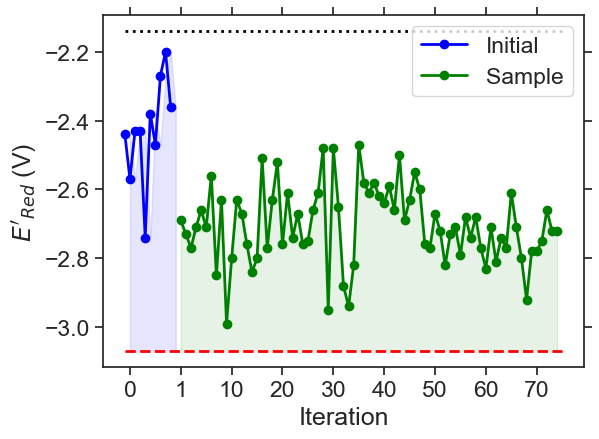

Nrun = 1


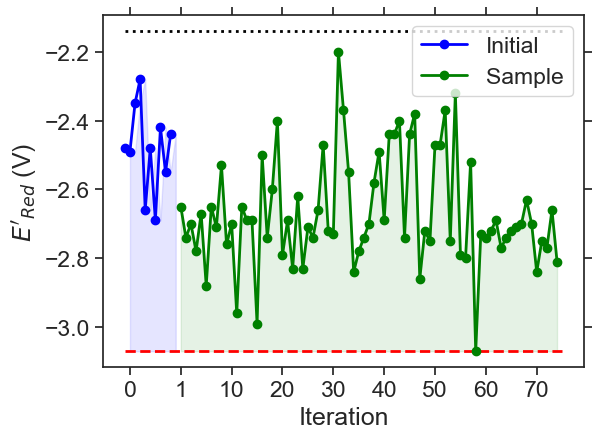

Nrun = 2


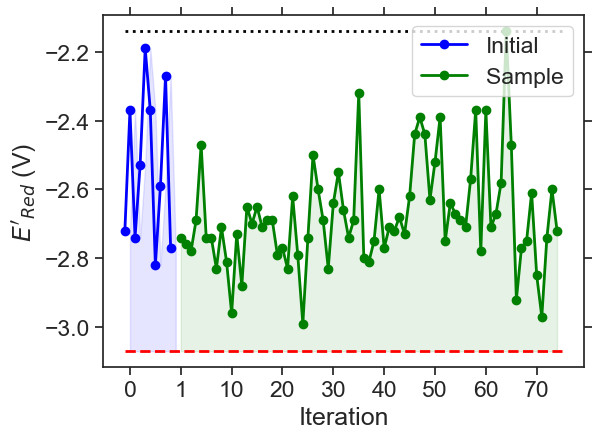

Nrun = 3


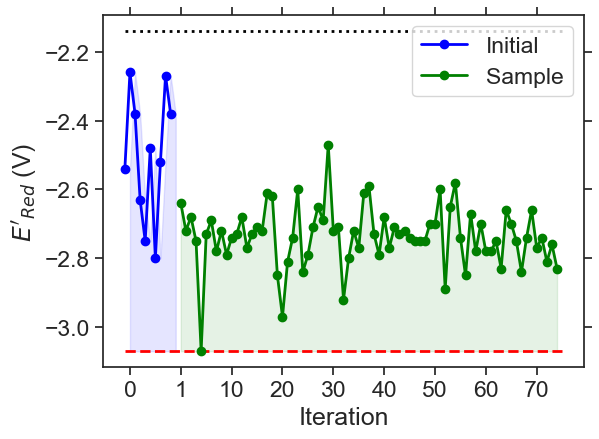

Nrun = 4


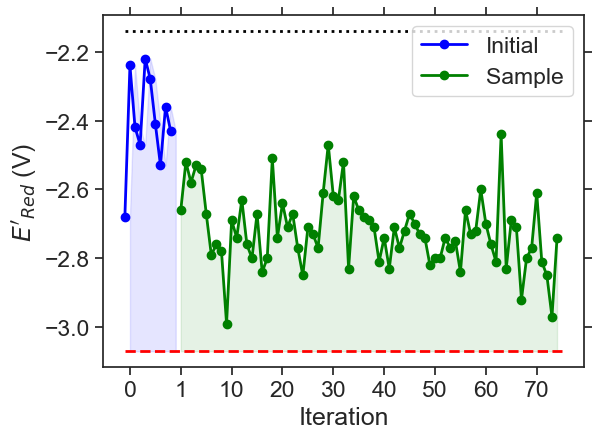

Nrun = 5


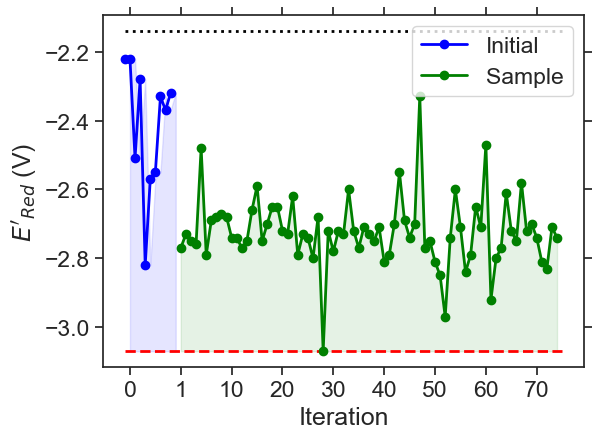

Nrun = 6


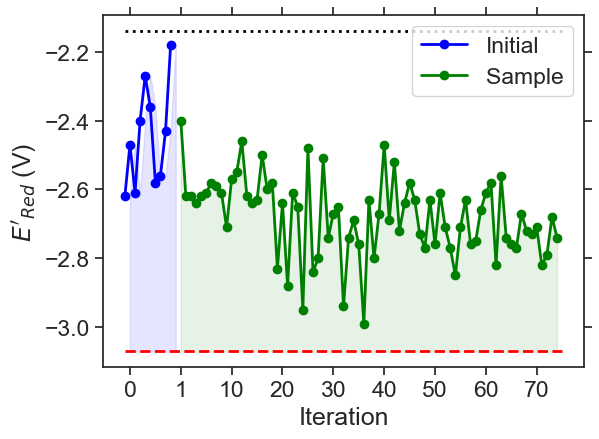

Nrun = 7


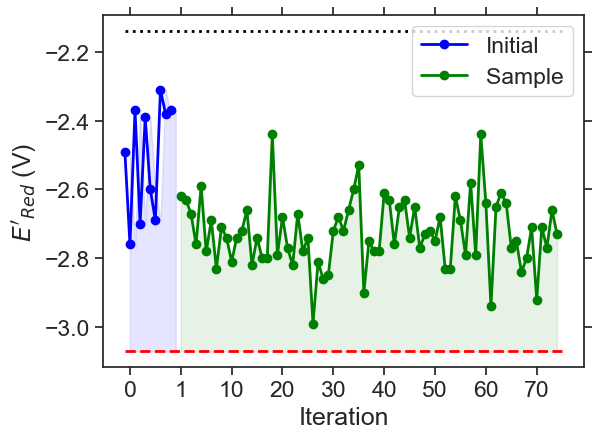

Nrun = 8


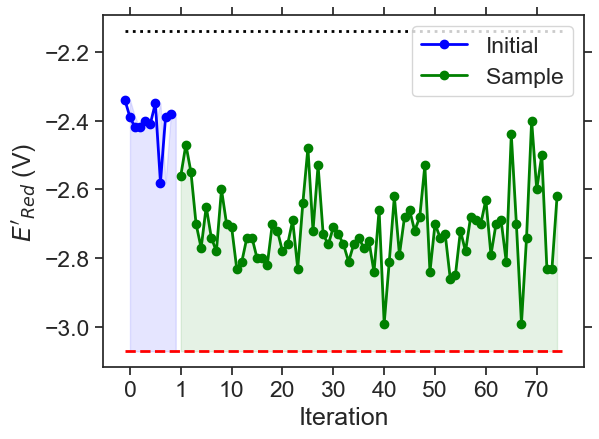

Nrun = 9


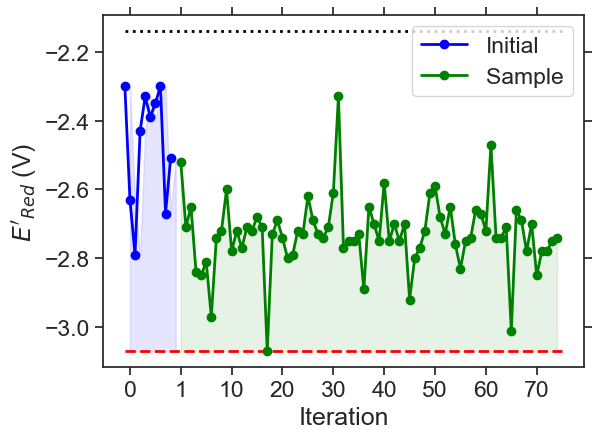

In [733]:
for jj in np.arange(Nruns):
    print(f"Nrun = {jj}")
    file=f"./BayesOptRunProgress_NR_{jj}"
    df_bo=pd.read_csv(file+".csv")
    df_bo.columns=['batch','Iteration','SMILES','Ered']
    plot_bo_progress(df=df_bo,filename=r"./df_stats_1500/"+file+".png")